In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.patheffects as path_effects

from Bio import SeqIO
import numpy as np

import glob,os,re

typeface='Arial'
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22
mpl.rcParams['pdf.fonttype']=42

base_path='/Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/'

def percent2dissim(matrix):
    convert=lambda percent: 1.0-(percent/100.0)
    
    for i,row in enumerate(matrix):
        for j,value in enumerate(matrix[i]):
            if i==j:
                matrix[i][j]=0.0
            elif j>i:
                matrix[i][j]=convert(matrix[i][j])
                matrix[j][i]=matrix[i][j]
    return matrix

def percent_id(seqA,seqB):
    invalid=lambda aa: aa=='-' or aa=='X'
    ident=0
    diffs=0
    total=0
    for a,b in zip(seqA,seqB):
        if a!=b:
            diffs+=1
            total+=1
        elif invalid(a) or invalid(b):
            pass
        else:
            ident+=1
            total+=1
            
    return (ident/total)*100.0

distance_matrices={}
seq_names={}

for aln_path in glob.glob(os.path.join(base_path,'Anello*.fasta')): ## iterate over fastas in folder
    aln=SeqIO.parse(aln_path,format='fasta') ## open alignment
    vir=os.path.basename(aln_path).split('.')[0].split('_')[0] ## get alignment stem name
    
    print(vir,aln_path)
    seqs=[]
    seq_names[vir]=[]
    for seq in aln:
        seq_names[vir].append(seq.id) ## remember names in alignment
        seqs.append(seq.seq) ## get sequences in alignment
    
    matrix_fname=aln_path.replace('.fasta','.p_matrix.tsv') ## generate distance matrix file name
    
    if os.path.isfile(matrix_fname): ## matrix file already exists
        matrix_file=open(matrix_fname,'r')
        
        distance_matrices[vir]=[]
        for line in matrix_file:
            l=line.strip('\n').split(',')
            if l[0]=='':
                cols=l[1:]
                seq_names[vir]=l[1:]
            else:
                distance_matrices[vir].append(list(map(float,[x if x!='' else 100.0 for x in l[1:]]))) ## read matrix in
                
        distance_matrices[vir]=percent2dissim(distance_matrices[vir]) ## convert to dissimilarity matrix
        print(len(distance_matrices[vir]))
    else: ## matrix file doesn't exist
        print('File %s does not exist'%(matrix_fname))

Anellos /Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/Anellos_ORF1.fasta
2101


In [2]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS

import colorsys
#### code stolen from seaborn to desaturate colours
def desaturate(color, prop):
    """Decrease the saturation channel of a color by some percent.
    Parameters
    ----------
    color : matplotlib color
        hex, rgb-tuple, or html color name
    prop : float
        saturation channel of color will be multiplied by this value
    Returns
    -------
    new_color : rgb tuple
        desaturated color code in RGB tuple representation
    """
    # Check inputs
    if not 0 <= prop <= 1:
        raise ValueError("prop must be between 0 and 1")

    # Get rgb tuple rep
    rgb = mpl.colors.colorConverter.to_rgb(color)

    # Convert to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)

    # Desaturate the saturation channel
    s *= prop

    # Convert back to rgb
    new_color = colorsys.hls_to_rgb(h, l, s)

    return new_color

cmap=mpl.cm.tab20

Ys={}
clusters={}
colours={}

mds=MDS(n_components=2,dissimilarity='precomputed')

for vir in distance_matrices:
    
    
    mds_file=os.path.join(base_path,'%s_MDS.csv'%(vir)) ## coordinates file
    print(mds_file)
    if os.path.exists(mds_file): ## if coordinates file available - load that
        Ys[vir]=[]
        for line in open(mds_file,'r'):
            strain,x,y=line.strip('\n').split(',')
            Ys[vir].append((float(x),float(y)))
            
    else: ## coordinates not available - redo MDS
        Ys[vir]=mds.fit_transform(distance_matrices[vir])
    
    ac=AgglomerativeClustering(n_clusters=10,affinity='precomputed',linkage='complete')
    clusters[vir]=ac.fit(distance_matrices[vir])
    print(vir,set(clusters[vir].labels_),len(clusters[vir].labels_))
    
    colours[vir]={c: desaturate(cmap(c/len(set(clusters[vir].labels_))),0.65) for c in set(clusters[vir].labels_)}

/Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/Anellos_MDS.csv
Anellos {0, 1, 2, 3, 4, 5, 6, 7, 8, 9} 2101


R02	#a6cee3
R03	#1f78b4
R04	#b2df8a
R05	#33a02c
R06	#fb9a99
R07	#e31a1c
R08	#fdbf6f
R09	#ff7f00
R10	#cab2d6
R11	#6a3d9a
R12	#ffff99
R13	#b15928
R14	lightgrey
R15	dimgrey
full convex hull area: 1.3454993496712406
R02	0.30563019885762277	0.227
R03	0.9316441696045921	0.692
R04	1.0615173494372612	0.789
R05	1.027009488671671	0.763
R06	0.0742014336451689	0.055
R07	0.7509010699561327	0.558
R08	0.6392903331839151	0.475
R09	0.6962482574552569	0.517
R11	0.7532513436677191	0.560
R12	0.5209194151399855	0.387
R13	0.3433866791600407	0.255
R14	0.673658609687543	0.501
R15	1.0573737969894919	0.786


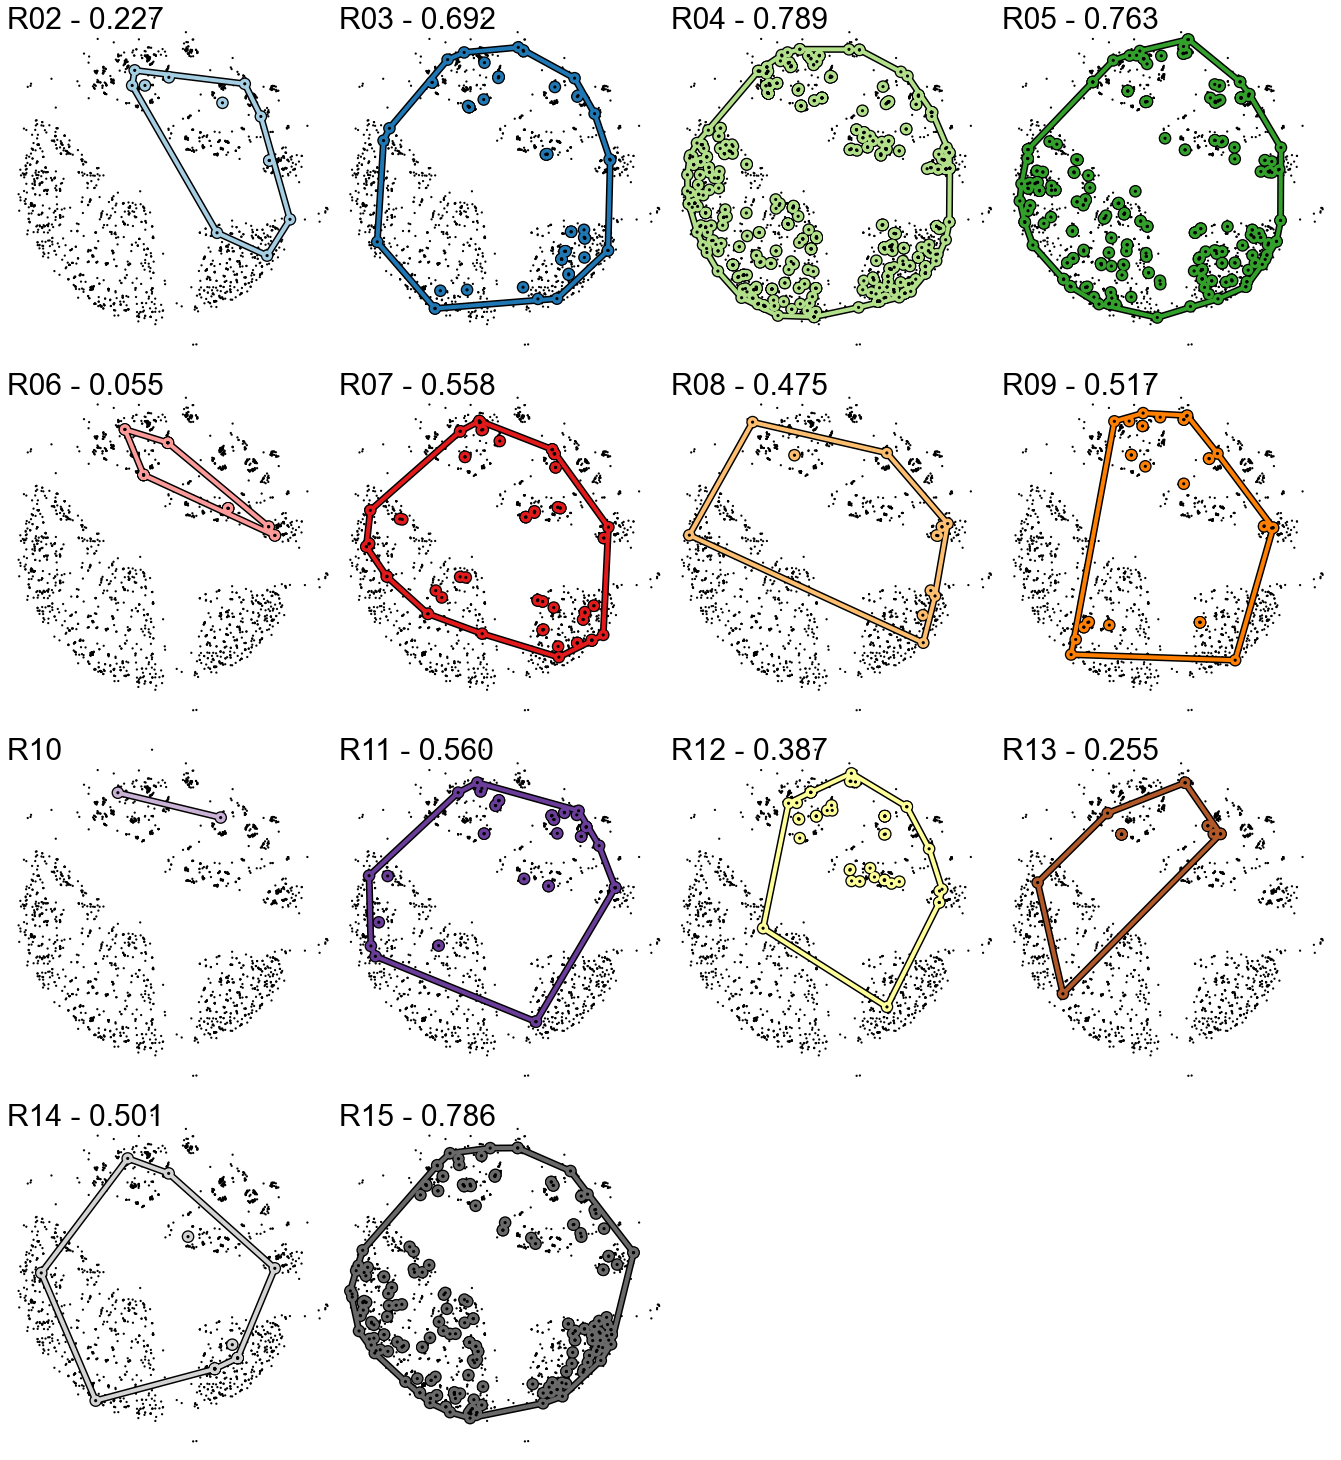

In [3]:
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as mpl_Polygon

study_recipient=re.compile('^(R[0-9]{2})T[0-9]{2}')
study_donor=re.compile('^(R[0-9]{2})D[0-9]{2}')

patients=set()
is_study={}
coordinates={}
all_coordinates=[]
patient_seqs={}
for n,name in enumerate(seq_names['Anellos']): ## iterate over sequences 
#     coordinates.append(Ys['Anellos'][n])
    rec=study_recipient.match(name)
    don=study_donor.match(name)
    
    all_coordinates.append(Ys['Anellos'][n])
    if rec or don:
        patient=rec.group(1) if rec else don.group(1)
        if patient not in coordinates: coordinates[patient]=[]
        if patient not in patient_seqs: patient_seqs[patient]=[]
        is_study[name]=True
        patients.add(patient)
        if rec:
            coordinates[patient].append(Ys['Anellos'][n])
            patient_seqs[patient].append(n)
    else:
        is_study[name]=False
    
patient_colours={}
Cs=['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928','lightgrey','dimgrey']
for p,patient in enumerate(sorted(patients)):
    print('%s\t%s'%(patient,Cs[p]))
    patient_colours[patient]=Cs[p]
    
fig = plt.figure(figsize=(11.89*2,13.45*2),facecolor='w')
cols=4
gs = gridspec.GridSpec(len(patients)//cols+1,cols,width_ratios=[1 for c in range(cols)],wspace=0.0,hspace=0.0) 

all_coordinates=np.array(all_coordinates)
hull = ConvexHull(all_coordinates)
sh_poly=Polygon(list(zip(all_coordinates[hull.vertices,0],all_coordinates[hull.vertices,1])))

print('full convex hull area:','%s'%(sh_poly.area))
total_area=sh_poly.area

# ax.plot
for p,patient in enumerate(sorted(patients)):
    distances=[]
    for a,A in enumerate(patient_seqs[patient]):
        for b,B in enumerate(patient_seqs[patient]):
            if b>a:
                distances.append(distance_matrices['Anellos'][A][B])
    
    row=p//cols
    col=p%cols
    
    ax=plt.subplot(gs[row,col])
    
    xs,ys=zip(*coordinates[patient])
    fc=patient_colours[patient]
    
    s=5
    ax.scatter(xs,ys,s=s*2,facecolor='k',edgecolor='none',zorder=4)
    ax.scatter(xs,ys,s=s*20,facecolor=fc,edgecolor='none',zorder=3)
    ax.scatter(xs,ys,s=s*32,facecolor='k',edgecolor='none',zorder=2)
    
    coords=np.array(np.array((xs,ys)).T)
    area=''
    
    if len(coords)>2:
        hull = ConvexHull(coords)
        for simplex in hull.simplices:
            ax.plot(coords[simplex,0],coords[simplex,1],color=fc,lw=4,ls='-',zorder=3)
            ax.plot(coords[simplex,0],coords[simplex,1],color='k',lw=7,ls='-',zorder=0)
            
        p=mpl_Polygon(list(zip(coords[hull.vertices,0],coords[hull.vertices,1])))
#         ax.add_patch(p)
        sh_poly=Polygon(list(zip(coords[hull.vertices,0],coords[hull.vertices,1])))
        
        print('%s\t%s\t%.3f'%(patient,sh_poly.area,sh_poly.area/total_area))
        
        area='- %.3f'%(sh_poly.area/total_area)
    else:
        ax.plot(*zip(coords[0],coords[1]),color=fc,lw=4,ls='-',zorder=3)
        ax.plot(*zip(coords[0],coords[1]),color='k',lw=7,ls='-',zorder=0)
    
    ax.text(0.0,1.0,'%s %s'%(patient,area),size=30,ha='left',va='top',transform=ax.transAxes)
    ax.scatter(*zip(*all_coordinates),s=s,facecolor='k',edgecolor='none',zorder=1)
    
    ax.set_aspect(1)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
#     ax.tick_params(size=0,labelsize=0)
    [ax.spines[loc].set_visible(False) for loc in ax.spines]
    axs,ays=zip(*all_coordinates)
    ax.set_xlim(min(axs)-0.05,max(axs)+0.05)
    ax.set_ylim(min(ays)-0.05,max(ays)+0.05)

plt.savefig('/Users/evogytis/Downloads/patient_anellomes.pdf',dpi=300,bbox_inches='tight')
plt.show()